In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import os
import re
import json

In [2]:
if not os.path.isdir('results'):
    os.system('tar xf z1_distributed.tar.gz')

In [3]:
root_path='results/zillow/Z1/'
paths = sorted(list(map(lambda p: os.path.join(root_path, p), os.listdir(root_path))))

In [4]:
paths

['results/zillow/Z1/aws-emr-run-1.log.txt',
 'results/zillow/Z1/aws-emr-run-1.txt',
 'results/zillow/Z1/aws-emr-run-1.txt.stderr',
 'results/zillow/Z1/aws-emr-run-10.log.txt',
 'results/zillow/Z1/aws-emr-run-10.txt',
 'results/zillow/Z1/aws-emr-run-10.txt.stderr',
 'results/zillow/Z1/aws-emr-run-11.log.txt',
 'results/zillow/Z1/aws-emr-run-11.txt',
 'results/zillow/Z1/aws-emr-run-11.txt.stderr',
 'results/zillow/Z1/aws-emr-run-2.log.txt',
 'results/zillow/Z1/aws-emr-run-2.txt',
 'results/zillow/Z1/aws-emr-run-2.txt.stderr',
 'results/zillow/Z1/aws-emr-run-3.log.txt',
 'results/zillow/Z1/aws-emr-run-3.txt',
 'results/zillow/Z1/aws-emr-run-3.txt.stderr',
 'results/zillow/Z1/aws-emr-run-4.log.txt',
 'results/zillow/Z1/aws-emr-run-4.txt',
 'results/zillow/Z1/aws-emr-run-4.txt.stderr',
 'results/zillow/Z1/aws-emr-run-5.log.txt',
 'results/zillow/Z1/aws-emr-run-5.txt',
 'results/zillow/Z1/aws-emr-run-5.txt.stderr',
 'results/zillow/Z1/aws-emr-run-6.log.txt',
 'results/zillow/Z1/aws-emr-run-6

In [5]:
!tail 'results/zillow/Z1/tuplex-compiled-run-3.txt.stderr'

2022-02-04 03:23:34,554:INFO: Running experiment with 120 concurrency, 10000MB Lambda memory, mode=compiled
2022-02-04 03:23:34,632:INFO: Tuplex startup time: 0.07747244834899902
2022-02-04 03:23:48,602:INFO: Tuplex job time: 13.969614505767822 s
2022-02-04 03:23:48,602:INFO: {"startupTime": 0.07747244834899902, "jobTime": 13.969614505767822}
2022-02-04 03:23:48,602:INFO: options={'tuplex.useLLVMOptimizer': True, 'tuplex.autoUpcast': False, 'tuplex.allowUndefinedBehavior': False, 'tuplex.optimizer.codeStats': False, 'tuplex.optimizer.generateParser': False, 'tuplex.optimizer.nullValueOptimization': False, 'tuplex.optimizer.filterPushdown': True, 'tuplex.optimizer.sharedObjectPropagation': True, 'tuplex.optimizer.mergeExceptionsInOrder': True, 'tuplex.optimizer.operatorReordering': False, 'tuplex.interleaveIO': True, 'tuplex.resolveWithInterpreterOnly': False, 'tuplex.network.verifySSL': False, 'tuplex.redirectToPythonLogging': False, 'tuplex.csv.selectionPushdown': True, 'tuplex.webui.

In [6]:
rows = []

for path in paths:
    try:
        if 'aws-emr' in path and path.endswith('txt.stderr'):
            line = open(path, 'r').readlines()[-2]

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])

            m = re.search(r'(\d+.\d+)s', line)
            job_time = float(m[1])

            rows.append({'framework' : 'aws-emr', 'job_time' : job_time, 'run': run})

        elif 'pywren' in path and path.endswith('.txt'):
            data = json.load(open(path, 'r'))

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])

            job_time = data['job_time']

            rows.append({'framework' : 'pywren', 'job_time' : job_time, 'run': run})
        elif 'tuplex' in path and path.endswith('txt.stderr'):
            # extract name -> tuplex-compiled or tuplex-interpreted
            fw = 'tuplex-compiled' if 'tuplex-compiled' in path else 'tuplex-interpreted'

            line = list(filter(lambda line: '"jobTime":' in line, open(path, 'r').readlines()))[0]
            line = line[line.find('{'):]
            data = json.loads(line)

            m = re.search(r'run-(\d+)', path)
            run = int(m[1])

            job_time = data['jobTime']

            rows.append({'framework' : fw, 'job_time' : job_time, 'run': run})
    except Exception as e:
        print('>>> bad file: ' + path)


>>> bad file: results/zillow/Z1/aws-emr-run-9.txt.stderr


In [7]:
df = pd.DataFrame(rows).sort_values(by='job_time').reset_index(drop=True)

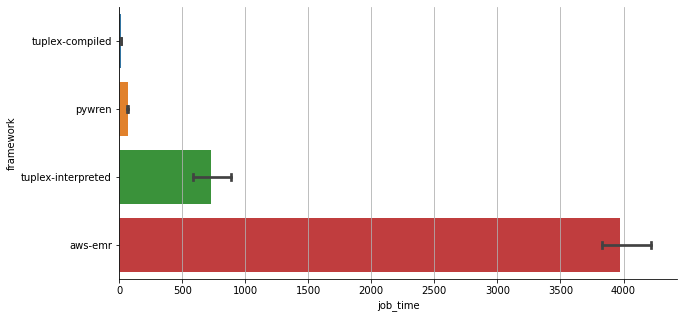

In [8]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, y='framework', x = 'job_time', capsize=.1)
#sns.boxplot(data=df, x='framework', y = 'job_time')
# plt.yscale('log')
plt.grid(axis='x')
sns.despine()

In [9]:
df.to_csv('zillow_Z1_distributed.csv', index=None)

In [10]:
df[['framework', 'job_time']].groupby('framework').describe().sort_values(by=('job_time', 'mean'))

job_time                                        \
                      count         mean         std          min   
framework                                                           
tuplex-compiled        11.0    16.480847    1.907574    13.969615   
pywren                 11.0    68.511083    6.482510    63.548484   
tuplex-interpreted     11.0   728.394932  283.467165   363.383731   
aws-emr                10.0  3972.866671  364.216276  3751.066321   

                                                                        
                            25%          50%          75%          max  
framework                                                               
tuplex-compiled       14.787935    16.181465    18.165119    19.093873  
pywren                65.613988    65.802774    66.391986    81.541633  
tuplex-interpreted   576.344713   692.594272   758.291702  1302.954115  
aws-emr             3820.890856  3894.968917  3901.943772  4995.993513

In [18]:
latex = df[['framework', 'job_time']].groupby('framework').describe().sort_values(by=('job_time', 'mean'))[[('job_time', 'mean'), ('job_time', 'std'), ('job_time', 'min'), ('job_time', 'max')]].to_latex(float_format="%.2f")

In [19]:
print(latex)

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{4}{l}{job\_time} \\
{} &     mean &    std &     min &     max \\
framework          &          &        &         &         \\
\midrule
tuplex-compiled    &    16.48 &   1.91 &   13.97 &   19.09 \\
pywren             &    68.51 &   6.48 &   63.55 &   81.54 \\
tuplex-interpreted &   728.39 & 283.47 &  363.38 & 1302.95 \\
aws-emr            &  3972.87 & 364.22 & 3751.07 & 4995.99 \\
\bottomrule
\end{tabular}

